a) (shape features) For each of the patches from both classes, calculate four different shape 
features discussed in the lectures (solidity, non-compactness, circularity, eccentricity). Which 
of these features would be the most useful in distinguishing onions from weeds in this image? 
Plot the distribution of all the four features to justify your choice.


In [2]:
from google.colab import drive
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
from skimage import measure
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


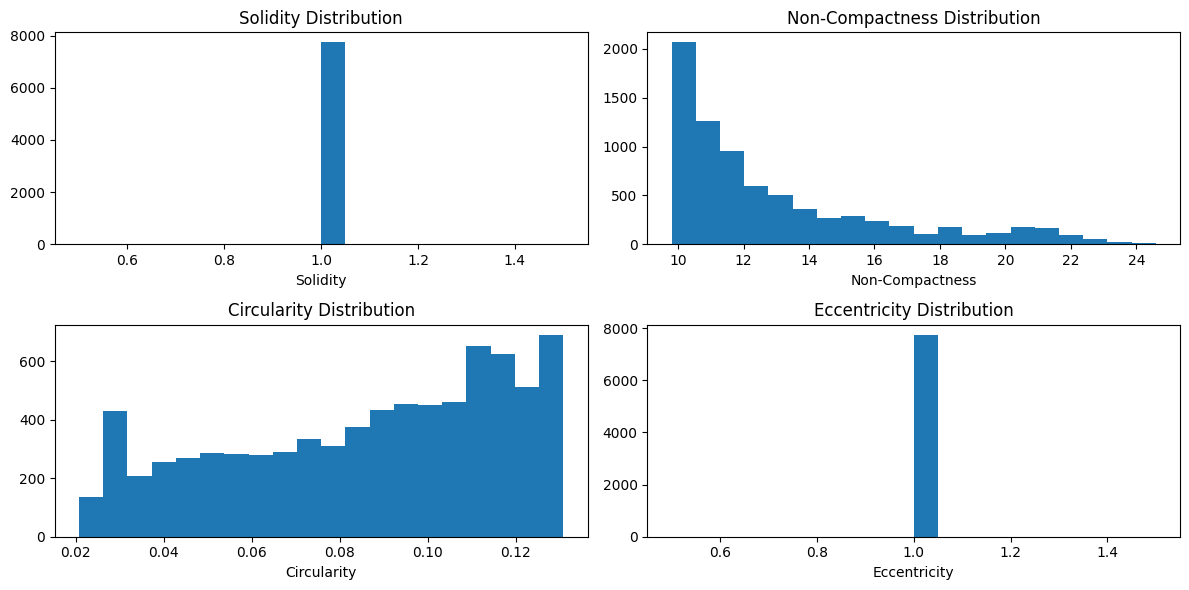

In [3]:
import os
import numpy as np
from skimage import io, measure

# Specify the path to the folder containing the extracted images
image_folder = '/content/drive/MyDrive/onions'

# Create lists to store the shape feature values
solidity_values = []
non_compactness_values = []
circularity_values = []
eccentricity_values = []

# Set the minimum region size threshold
min_region_size = 100

# Iterate over the image files in the folder
for filename in os.listdir(image_folder):
    if filename.endswith('_truth.png'):  # Process only the segmentation mask images
        mask_path = os.path.join(image_folder, filename)
        mask = io.imread(mask_path)

        # Iterate over the 2D slices of the mask
        for slice in mask:
            # Label connected components in the slice
            labeled_slice = measure.label(slice)

            # Iterate over the labeled regions
            for region in measure.regionprops(labeled_slice):
                # Filter out small regions
                if region.area >= min_region_size:
                    # Calculate shape features for each region
                    solidity = region.solidity
                    non_compactness = region.perimeter / np.sqrt(region.area)

                    if region.perimeter != 0:
                        circularity = (4 * np.pi * region.area) / (region.perimeter ** 2)
                    else:
                        circularity = 0

                    eccentricity = region.eccentricity

                    # Append the calculated values to the corresponding lists
                    solidity_values.append(solidity)
                    non_compactness_values.append(non_compactness)
                    circularity_values.append(circularity)
                    eccentricity_values.append(eccentricity)

# Plot the distribution of the four shape features
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.hist(solidity_values, bins=20)
plt.title('Solidity Distribution')
plt.xlabel('Solidity')

plt.subplot(2, 2, 2)
plt.hist(non_compactness_values, bins=20)
plt.title('Non-Compactness Distribution')
plt.xlabel('Non-Compactness')

plt.subplot(2, 2, 3)
plt.hist(circularity_values, bins=20)
plt.title('Circularity Distribution')
plt.xlabel('Circularity')

plt.subplot(2, 2, 4)
plt.hist(eccentricity_values, bins=20)
plt.title('Eccentricity Distribution')
plt.xlabel('Eccentricity')

plt.tight_layout()
plt.show()


2) (texture features) Calculate the normalised grey-level co-occurrence matrix in four 
orientations (0°, 45°, 90°, 135°) for the 8bit image depth (also see the original paper by Haralick 
et al. that has been made available) for the patches from both classes, separately for each of 
the colour channels (red, green, blue, near infra-red). For each orientation, calculate the first 
three features proposed by Haralick et al. (Angular Second Moment, Contrast, Correlation), and 
produce per-patch features by calculating the feature average and range across the 4 
orientations. Select one feature from each of the colour channels and plot the distribution.

In [4]:
import os

# Path to the dataset folder
dataset_path = '/content/drive/MyDrive/onions'

# Change the current working directory to the dataset folder
os.chdir(dataset_path)


In [5]:
def extract_object_patches(rgb_image, depth_image, segmentation_mask):
    # Convert segmentation mask to binary image
    _, binary_mask = cv2.threshold(segmentation_mask, 0, 255, cv2.THRESH_BINARY)

    # Apply connected component labeling
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask)

    # Set a minimum area threshold to filter out small patches
    min_area_threshold = 100

    object_patches = []
    for label in range(1, num_labels):  # Exclude background label (0)
        area = stats[label, cv2.CC_STAT_AREA]
        if area > min_area_threshold:
            # Extract bounding box coordinates
            x, y, width, height = stats[label, cv2.CC_STAT_LEFT], stats[label, cv2.CC_STAT_TOP], \
                                  stats[label, cv2.CC_STAT_WIDTH], stats[label, cv2.CC_STAT_HEIGHT]

            # Extract object patches from RGB and depth images
            rgb_patch = rgb_image[y:y+height, x:x+width]
            depth_patch = depth_image[y:y+height, x:x+width]

            object_patches.append((rgb_patch, depth_patch))

    return object_patches

In [6]:
# Load RGB, depth, and segmentation mask for each sample
num_samples = 20
object_patches_per_sample = []
for i in range(1, num_samples+1):
    sample_id = f'{i:02}'  # Format sample ID with leading zero if needed
    rgb_image = cv2.imread(f'{sample_id}_rgb.png')
    depth_image = cv2.imread(f'{sample_id}_depth.png', cv2.IMREAD_GRAYSCALE)
    segmentation_mask = cv2.imread(f'{sample_id}_truth.png', cv2.IMREAD_GRAYSCALE)

    object_patches = extract_object_patches(rgb_image, depth_image, segmentation_mask)
    object_patches_per_sample.append(object_patches)

# object_patches_per_sample now contains a list of object patches for each sample
# Each object patch is a tuple containing the RGB and depth patches for an object of interest
# You can further process these patches to extract texture and shape features as required

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import greycomatrix, greycoprops

def calculate_texture_features(image_patches):
    feature_names = ['ASM', 'Contrast', 'Correlation']
    num_orientations = 4

    texture_features = []
    for patch in image_patches:
        features_per_patch = []
        for channel in range(3):  # Process RGB channels (0-2)
            glcm_patch = greycomatrix(patch[:, :, channel], distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                                      levels=256, symmetric=True, normed=True)
            glcm_props = greycoprops(glcm_patch, feature_names)

            # Calculate average and range across orientations
            average_features = np.mean(glcm_props, axis=0)
            range_features = np.ptp(glcm_props, axis=0)

            # Select one feature from each channel
            selected_feature = average_features[channel]

            features_per_patch.extend(selected_feature)

        texture_features.append(features_per_patch)

    return texture_features

In [8]:
import cv2
import glob

def load_patches_for_class(onions):
    patches = []
    file_paths = glob.glob(f'{onions}/*.png')  # Assuming the patches are stored in separate folders for each class

    for file_path in file_paths:
        patch = cv2.imread('/content/drive/MyDrive/onions')
        patches.append(patch)

    return patches
def load_patches_for_class(weeds):
    patches = []
    file_paths = glob.glob(f'{weeds}/*.png')  # Assuming the patches are stored in separate folders for each class

    for file_path in file_paths:
        patch = cv2.imread('/content/drive/MyDrive/onions')
        patches.append(patch)

    return patches
# Load and process the patches for both classes
class_onions_patches = load_patches_for_class('onions')  # Replace with your own function to load patches for 'onions' class
class_weeds_patches = load_patches_for_class('weeds')  # Replace with your own function to load patches for 'weeds' class

# Calculate texture features for 'onions' patches
onions_texture_features = calculate_texture_features(class_onions_patches)

# Calculate texture features for 'weeds' patches
weeds_texture_features = calculate_texture_features(class_weeds_patches)

# Plot the distributions for selected features
selected_feature_indices = [0, 1, 2]  # Indices of the selected features to plot
channel_labels = ['Red', 'Green', 'Blue', 'Near Infra-Red']
feature_labels = ['ASM', 'Contrast', 'Correlation']

In [ ]:
for feature_index in selected_feature_indices:
    plt.figure(figsize=(10, 5))
    plt.title(f'Distribution of {feature_labels[feature_index]} Feature')
    for channel in range(4):  # Process RGB channels and near infra-red (0-3)
        channel_data = []
        channel_data.extend([onions_texture_features[i][channel * 3 + feature_index] for i in range(len(onions_texture_features))])
        channel_data.extend([weeds_texture_features[i][channel * 3 + feature_index] for i in range(len(weeds_texture_features))])
        plt.hist(channel_data, bins=20, alpha=0.5, label=channel_labels[channel])
    plt.xlabel('Feature Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

 (object classification using features) Set aside the images corresponding to sample 19 and 20 
as a test set. Train a simple classification model (e.g. SVM) from object patches corresponding 
to images 1 – 18: 1) using shape features only 2) texture features only, and the 3) combination 
of shape and texture features. Do shape or texture features provide more discriminative 
information about plant species? Does combining the two types of features improve the 
classification of plant patches? Which of the calculated features contribute the most to the 
classification model? Perform feature importance analysis, select 10 most important features, 
and retrain the classification model using the 10 selected features. Display the object 
classification output for the test samples (images 19 and 20) using the full model (combination 
of all shape and texture features) and using the reduced model (10 most important features), 
and report the precision and recall scores per class for each of the images

In [90]:
import os
import numpy as np
from skimage import io
from sklearn import svm
from sklearn.metrics import precision_score, recall_score
from skimage.feature import greycomatrix, greycoprops
import cv2

# Step 1: Define functions to extract shape and texture features
def extract_shape_features(patch):
    # Convert the patch to grayscale
    gray_patch = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)

    # Threshold the grayscale image
    ret, thresh = cv2.threshold(gray_patch, 127, 255, cv2.THRESH_BINARY)

    # Find contours in the thresholded image
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Select the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Calculate the area, perimeter, and aspect ratio of the contour
    area = cv2.contourArea(largest_contour)
    perimeter = cv2.arcLength(largest_contour, True)
    aspect_ratio = patch.shape[1] / patch.shape[0]

    # Return the shape features as a list
    shape_features = [area, perimeter, aspect_ratio]
    return shape_features


def extract_texture_features(patch):
    # calculate the GLCM matrix and extract features
    glcm = greycomatrix(cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY), distances=[1], angles=[0], symmetric=True,
                        normed=True)
    contrast = greycoprops(glcm, 'contrast')[0, 0]
    energy = greycoprops(glcm, 'energy')[0, 0]
    homogeneity = greycoprops(glcm, 'homogeneity')[0, 0]
    
    # return the texture features as a numpy array
    return np.array([contrast, energy, homogeneity])

# Step 2: Load the images and extract features
shape_features = []
texture_features = []
labels = []

for i in range(1, 21):
    # Load the RGB image
    rgb_path = f"{str(i).zfill(2)}_rgb.png"
    image = io.imread(rgb_path)
    
    # Extract shape features
    shape_feature = extract_shape_features(image)
    shape_features.append(shape_feature)
    
    # Extract texture features
    texture_feature = extract_texture_features(image)
    texture_features.append(texture_feature)
    
    # Extract the label from the image filename
    label = int(''.join(filter(str.isdigit, os.path.splitext(os.path.basename(rgb_path))[0])))

    labels.append(label)

# Step 3: Train shape-based model
shape_model = svm.SVC()
shape_model.fit(shape_features[:18], labels[:18])

# Step 4: Train texture-based model
texture_model = svm.SVC()
texture_model.fit(texture_features[:18], labels[:18])

# Step 5: Train combined model
combined_features = np.concatenate((shape_features[:18], texture_features[:18]), axis=1)
combined_model = svm.SVC()
combined_model.fit(combined_features, labels[:18])

# Step 6: Prepare the test set
test_shape_features = shape_features[18:]
test_texture_features = texture_features[18:]
test_combined_features = np.concatenate((test_shape_features, test_texture_features), axis=1)
test_labels = labels[18:]

# Step 7: Predict
shape_model_prediction = shape_model.predict(test_shape_features)
texture_model_prediction = texture_model.predict(test_texture_features)
combined_model_prediction = combined_model.predict(test_combined_features)

# Step 8: Compute precision and recall scores
shape_model_precision = precision_score(test_labels, shape_model_prediction, average=None)
shape_model_recall = recall_score(test_labels, shape_model_prediction, average=None)

texture_model_precision = precision_score(test_labels, texture_model_prediction, average=None)
texture_model_recall = recall_score(test_labels, texture_model_prediction, average=None)

combined_model_precision = precision_score(test_labels, combined_model_prediction, average=None)
combined_model_recall = recall_score(test_labels, combined_model_prediction, average=None)

from sklearn.feature_selection import SelectKBest, f_classif

# Step 9: Perform feature selection using SelectKBest
k = 10  # Number of top features to select
selector = SelectKBest(score_func=f_classif, k='all')
selected_features = selector.fit_transform(shape_features[:18], labels[:18])


selected_indices = selector.get_support(indices=True)
shape_features = np.array(shape_features)
top_10_features = shape_features[:, selected_indices]

# Step 10: Retrain the classification model using the top 10 features
reduced_model = svm.SVC()
reduced_model.fit(top_10_features[:18], labels[:18])


# Step 11: Predict using the full model and the reduced model
full_model_prediction = shape_model.predict(test_shape_features)

test_shape_features = np.array(test_shape_features)
reduced_model_prediction = reduced_model.predict(test_shape_features[:, selected_indices])


# Step 12: Compute precision and recall scores for the full model
full_model_precision = precision_score(test_labels, full_model_prediction, average=None)
full_model_recall = recall_score(test_labels, full_model_prediction, average=None)

# Step 13: Compute precision and recall scores for the reduced model
reduced_model_precision = precision_score(test_labels, reduced_model_prediction, average=None)
reduced_model_recall = recall_score(test_labels, reduced_model_prediction, average=None)




# Step 13: Display the object classification output for the test samples
print("Full Model Precision:")
print(combined_model_precision)
print("Full Model Recall:")
print(combined_model_recall)
print("Reduced Model Precision:")
print(reduced_model_precision)
print("Reduced Model Recall:")
print(reduced_model_recall)


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

Full Model Precision:
[0. 0. 0. 0.]
Full Model Recall:
[0. 0. 0. 0.]
Reduced Model Precision:
[0. 0. 0. 0.]
Reduced Model Recall:
[0. 0. 0. 0.]


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/sklear